In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [3]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [4]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

D:\AnaconDA\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [5]:
#对时间序列进行分析
#总的销售趋势2013-2015年
# train['date'] = pd.to_datetime(train.Date)
# data = train.loc[:,['Sales']]
# data = data.set_index(train.date)
# data.plot()

# weekly = data.resample('W').sum()
# weekly.plot()

# dayily = data.resample('D').sum()
# dayily.plot()

In [6]:
TESTID = test['Id']

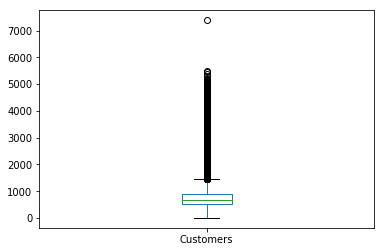

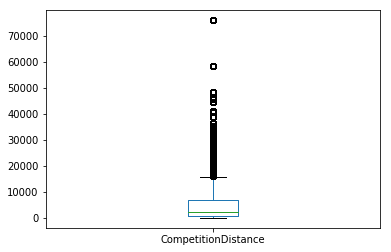

In [7]:
train.Customers.plot(kind='box')
plt.show()
train.CompetitionDistance.plot(kind='box')
plt.show()

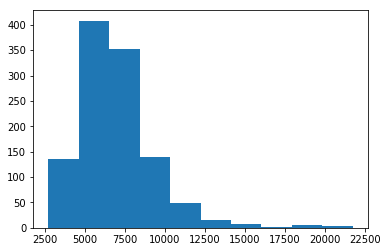

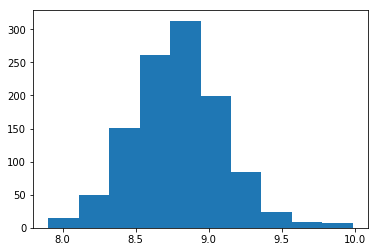

In [8]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [9]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [10]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #CART回归树不需要预处理数据和NAn值
#     distance_max = max(data.CompetitionDistance)
#     data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
#     print(data.CompetitionDistance.isnull().any())
#     min_max_scaler = MinMaxScaler()
#     scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
#     data.drop("CompetitionDistance",axis=1)
#     data['CompetitionDistance'] = scaledata
    #时间序列问题 需要考虑进时间的因素
    data['Year'] = data.Date.dt.year
    print(data['Year'].dtype)
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    
    if istrain:
        data.drop(['Store','Open','Date','Customers','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Store','Open','Date','Customers','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    else:
        data.drop(['Id','Store','Open','Date','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Id','Store','Open','Date','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    print(data.columns)

In [11]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

int64
Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
int64
Index(['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


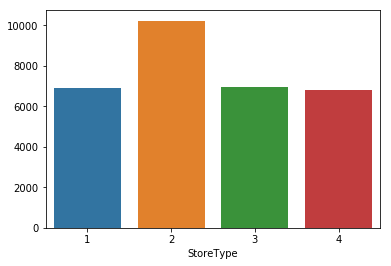

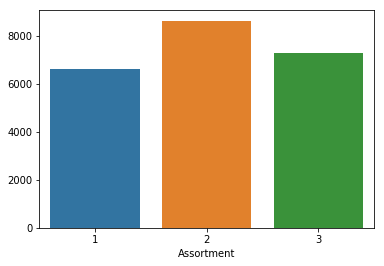

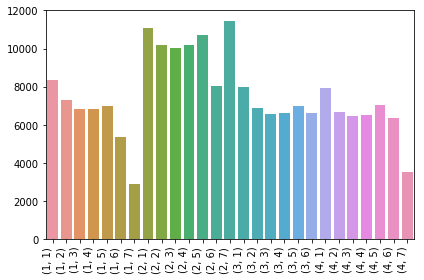

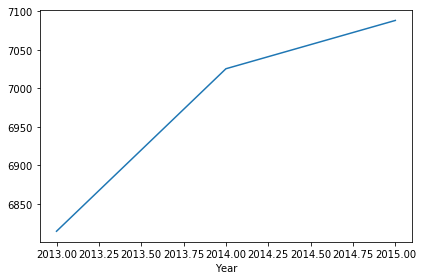

In [12]:
ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
import seaborn as sns
sns.barplot(ST_gp.index,ST_gp.values)
plt.show()

As_gp = train.groupby('Assortment')['Sales'].agg('mean')
sns.barplot(As_gp.index,As_gp.values)
plt.show()
Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#每年销售额的趋势
YearS_gp = train.groupby(['Year'])['Sales'].agg("mean")
ax2 = sns.lineplot(YearS_gp.index,YearS_gp.values)
plt.tight_layout()
plt.show()

In [13]:
#去除Nan数据

train.CompetitionDistance.fillna(0,inplace=True)
train.CompetitionOpenSinceMonth.fillna(0,inplace=True)
train.CompetitionOpenSinceYear.fillna(0,inplace=True)
train.Promo2SinceWeek.fillna(0,inplace=True)
train.Promo2SinceYear.fillna(0,inplace=True)

In [14]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
print(X_train.shape)
print(X_valid.shape)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

(834259, 16)
(10133, 16)


D:\AnaconDA\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


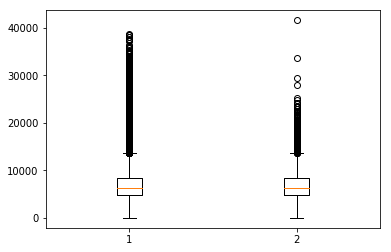

In [15]:
plt.boxplot([Y_train,Y_valid])
plt.show()

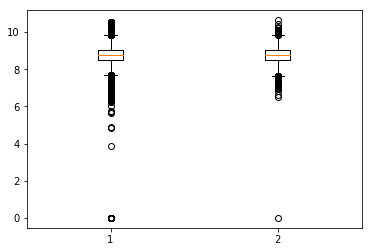

In [16]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [17]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [19]:
params = {"objective": "reg:linear",
          "eta": 0.1,
          "max_depth": 12,
          "min_child_weight":1,
          "gamma" :0,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 1000

# dtrain = xgb.DMatrix(X_train, Y_train)
# dvalid = xgb.DMatrix(X_valid, Y_valid)
# dtest = xgb.DMatrix(test)
eval_set= [(X_train, Y_train),(X_valid, Y_valid)]
#watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
ret = {}
import time
start = time.time()
estimator = xgb.XGBRegressor(max_depth=12,learning_rate =0.1,n_jobs =4, n_estimators=num_trees,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1)
estimator.fit(X_train, Y_train,eval_metric=rmspe_xg, eval_set=eval_set, verbose=True,early_stopping_rounds=20)
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()
print("Train use time:",end-start)

D:\AnaconDA\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:7.44319	validation_1-rmse:7.43877	validation_0-rmspe:0.999496	validation_1-rmspe:0.999476
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70071	validation_1-rmse:6.69673	validation_0-rmspe:0.998792	validation_1-rmspe:0.99877


KeyboardInterrupt: 

In [20]:
from matplotlib import pyplot
results = estimator.evals_result()
epochs = len(results['validation_0']['rmspe'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmspe'], label='Train')
ax.plot(x_axis, results['validation_1']['rmspe'], label='Test')
ax.legend()
pyplot.ylabel('Rmspe Loss')
pyplot.title('XGBoost Rmspe Loss')
pyplot.show()

AttributeError: 'XGBRegressor' object has no attribute 'evals_result_'

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

def customer_rmspe_xg(yhat, y):
    # y = y.values
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return rmspe

param_test1 = {
 'max_depth':range(10,13,1),
 #'subsample': [0.7,0.8,0.9],
 #'learning_rate': [0.08,0.1,0.11]
}
params_fit = {
    'eval_metric':rmspe_xg,
    'early_stopping_rounds':20,
    'eval_set':eval_set
}
nums_round = 492
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=12,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test1,cv=3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch1.fit(X_train, Y_train)

D:\AnaconDA\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] max_depth=10 ....................................................


KeyboardInterrupt: 

In [22]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [23]:
param_test2 = {
 'subsample': [0.8,0.9],
}

nums_round = 492
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test2,cv=3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch2.fit(X_train, Y_train)

D:\AnaconDA\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] subsample=0.8 ...................................................
[0]	validation_0-rmse:7.44332	validation_1-rmse:7.43878	validation_0-rmspe:0.999496	validation_1-rmspe:0.999476
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70085	validation_1-rmse:6.69668	validation_0-rmspe:0.998792	validation_1-rmspe:0.99877
[2]	validation_0-rmse:6.03268	validation_1-rmse:6.02902	validation_0-rmspe:0.997522	validation_1-rmspe:0.997495
[3]	validation_0-rmse:5.43172	validation_1-rmse:5.42833	validation_0-rmspe:0.995374	validation_1-rmspe:0.995342
[4]	validation_0-rmse:4.89081	validation_1-rmse:4.88764	validation_0-rmspe:0.991982	validation_1-rmspe:0.991942


KeyboardInterrupt: 

In [24]:
print(gsearch2.best_params_)
print(gsearch2.best_estimator_)
best_model = gsearch2.best_estimator_
from sklearn.externals import joblib
joblib.dump(best_model, "current_model.m")

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [25]:
param_test3 = {
 'eta': [0.08,0.1,0,12,0,15,0,2],
}

nums_round = 492
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch3.fit(X_train, Y_train)

D:\AnaconDA\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
D:\AnaconDA\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] eta=0.08 ........................................................


KeyboardInterrupt: 

In [26]:
print(gsearch3.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [27]:
param_test4 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

nums_round = 492
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test4,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch4.fit(X_train, Y_train)

D:\AnaconDA\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=0.0 .......................................................
[0]	validation_0-rmse:7.44332	validation_1-rmse:7.43878	validation_0-rmspe:0.999496	validation_1-rmspe:0.999476
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.


KeyboardInterrupt: 

In [28]:
print(gsearch4.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [30]:

estimator = xgb.XGBRegressor(max_depth=12,learning_rate =0.1,n_jobs =4, gamma = 0.4,n_estimators=num_trees,subsample=0.8,colsample_bytree=0.7,nthread=4,scale_pos_weight=1)
estimator.fit(X_train, Y_train,eval_metric=rmspe_xg, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:7.44335	validation_1-rmse:7.4389	validation_0-rmspe:0.999495	validation_1-rmspe:0.999475
[1]	validation_0-rmse:6.70119	validation_1-rmse:6.69701	validation_0-rmspe:0.998787	validation_1-rmspe:0.998764
[2]	validation_0-rmse:6.03301	validation_1-rmse:6.02921	validation_0-rmspe:0.997513	validation_1-rmspe:0.997486
[3]	validation_0-rmse:5.43198	validation_1-rmse:5.42842	validation_0-rmspe:0.995363	validation_1-rmspe:0.995329
[4]	validation_0-rmse:4.89113	validation_1-rmse:4.88789	validation_0-rmspe:0.991965	validation_1-rmspe:0.991921
[5]	validation_0-rmse:4.40453	validation_1-rmse:4.40177	validation_0-rmspe:0.986877	validation_1-rmspe:0.986824
[6]	validation_0-rmse:3.96673	validation_1-rmse:3.96414	validation_0-rmspe:0.979652	validation_1-rmspe:0.979584
[7]	validation_0-rmse:3.57283	validation_1-rmse:3.57065	validation_0-rmspe:0.969861	validation_1-rmspe:0.96978
[8]	validation_0-rmse:3.21825	validation_1-rmse:3.21618	validation_0-rmspe:0.957137	validation_1-rmspe:0.9

[72]	validation_0-rmse:0.167279	validation_1-rmse:0.177848	validation_0-rmspe:0.204328	validation_1-rmspe:0.165796
[73]	validation_0-rmse:0.166779	validation_1-rmse:0.177594	validation_0-rmspe:0.204039	validation_1-rmspe:0.165544
[74]	validation_0-rmse:0.166552	validation_1-rmse:0.177358	validation_0-rmspe:0.204113	validation_1-rmspe:0.165358
[75]	validation_0-rmse:0.165604	validation_1-rmse:0.176455	validation_0-rmspe:0.203337	validation_1-rmspe:0.164475
[76]	validation_0-rmse:0.165141	validation_1-rmse:0.176112	validation_0-rmspe:0.203021	validation_1-rmspe:0.164175
[77]	validation_0-rmse:0.164809	validation_1-rmse:0.175863	validation_0-rmspe:0.202555	validation_1-rmspe:0.163985
[78]	validation_0-rmse:0.164373	validation_1-rmse:0.175466	validation_0-rmspe:0.202136	validation_1-rmspe:0.163562
[79]	validation_0-rmse:0.163571	validation_1-rmse:0.17486	validation_0-rmspe:0.201517	validation_1-rmspe:0.162934
[80]	validation_0-rmse:0.161807	validation_1-rmse:0.173228	validation_0-rmspe:0.1

[144]	validation_0-rmse:0.13046	validation_1-rmse:0.146859	validation_0-rmspe:0.159316	validation_1-rmspe:0.128814
[145]	validation_0-rmse:0.13	validation_1-rmse:0.146521	validation_0-rmspe:0.158998	validation_1-rmspe:0.128351
[146]	validation_0-rmse:0.129808	validation_1-rmse:0.146358	validation_0-rmspe:0.158823	validation_1-rmspe:0.128139
[147]	validation_0-rmse:0.129448	validation_1-rmse:0.146037	validation_0-rmspe:0.158456	validation_1-rmspe:0.127751
[148]	validation_0-rmse:0.129348	validation_1-rmse:0.146009	validation_0-rmspe:0.158403	validation_1-rmspe:0.127722
[149]	validation_0-rmse:0.128913	validation_1-rmse:0.145597	validation_0-rmspe:0.157958	validation_1-rmspe:0.127264
[150]	validation_0-rmse:0.128831	validation_1-rmse:0.145534	validation_0-rmspe:0.157913	validation_1-rmspe:0.127201
[151]	validation_0-rmse:0.128666	validation_1-rmse:0.145458	validation_0-rmspe:0.155936	validation_1-rmspe:0.127123
[152]	validation_0-rmse:0.128497	validation_1-rmse:0.14539	validation_0-rmspe

[215]	validation_0-rmse:0.11997	validation_1-rmse:0.140569	validation_0-rmspe:0.143345	validation_1-rmspe:0.120902
[216]	validation_0-rmse:0.119894	validation_1-rmse:0.1405	validation_0-rmspe:0.143251	validation_1-rmspe:0.120845
[217]	validation_0-rmse:0.119818	validation_1-rmse:0.140463	validation_0-rmspe:0.143212	validation_1-rmspe:0.120805
[218]	validation_0-rmse:0.119778	validation_1-rmse:0.140454	validation_0-rmspe:0.138981	validation_1-rmspe:0.120792
[219]	validation_0-rmse:0.11975	validation_1-rmse:0.140449	validation_0-rmspe:0.138963	validation_1-rmspe:0.120785
[220]	validation_0-rmse:0.119601	validation_1-rmse:0.140403	validation_0-rmspe:0.138863	validation_1-rmspe:0.120702
[221]	validation_0-rmse:0.119565	validation_1-rmse:0.140391	validation_0-rmspe:0.138864	validation_1-rmspe:0.120688
[222]	validation_0-rmse:0.119467	validation_1-rmse:0.140328	validation_0-rmspe:0.138814	validation_1-rmspe:0.120594
[223]	validation_0-rmse:0.119406	validation_1-rmse:0.140267	validation_0-rms

[286]	validation_0-rmse:0.11593	validation_1-rmse:0.138753	validation_0-rmspe:0.132913	validation_1-rmspe:0.118614
[287]	validation_0-rmse:0.115914	validation_1-rmse:0.138744	validation_0-rmspe:0.132912	validation_1-rmspe:0.118602
[288]	validation_0-rmse:0.115868	validation_1-rmse:0.13871	validation_0-rmspe:0.132866	validation_1-rmspe:0.118583
[289]	validation_0-rmse:0.11582	validation_1-rmse:0.138665	validation_0-rmspe:0.132821	validation_1-rmspe:0.11851
[290]	validation_0-rmse:0.115755	validation_1-rmse:0.138641	validation_0-rmspe:0.13278	validation_1-rmspe:0.118484
[291]	validation_0-rmse:0.115731	validation_1-rmse:0.13862	validation_0-rmspe:0.13276	validation_1-rmspe:0.118455
[292]	validation_0-rmse:0.115706	validation_1-rmse:0.138622	validation_0-rmspe:0.132746	validation_1-rmspe:0.118456
[293]	validation_0-rmse:0.115641	validation_1-rmse:0.138578	validation_0-rmspe:0.132703	validation_1-rmspe:0.118401
[294]	validation_0-rmse:0.11552	validation_1-rmse:0.138487	validation_0-rmspe:0

[357]	validation_0-rmse:0.113368	validation_1-rmse:0.137859	validation_0-rmspe:0.12847	validation_1-rmspe:0.117132
[358]	validation_0-rmse:0.113351	validation_1-rmse:0.13785	validation_0-rmspe:0.128442	validation_1-rmspe:0.117127
[359]	validation_0-rmse:0.113319	validation_1-rmse:0.137822	validation_0-rmspe:0.128411	validation_1-rmspe:0.117094
[360]	validation_0-rmse:0.113292	validation_1-rmse:0.137812	validation_0-rmspe:0.128387	validation_1-rmspe:0.117097
[361]	validation_0-rmse:0.113245	validation_1-rmse:0.137787	validation_0-rmspe:0.128358	validation_1-rmspe:0.117068
[362]	validation_0-rmse:0.113227	validation_1-rmse:0.137787	validation_0-rmspe:0.128319	validation_1-rmspe:0.117071
[363]	validation_0-rmse:0.113183	validation_1-rmse:0.137782	validation_0-rmspe:0.128287	validation_1-rmspe:0.117075
[364]	validation_0-rmse:0.11316	validation_1-rmse:0.13778	validation_0-rmspe:0.128275	validation_1-rmspe:0.117073
[365]	validation_0-rmse:0.113116	validation_1-rmse:0.137754	validation_0-rms

[428]	validation_0-rmse:0.111273	validation_1-rmse:0.137027	validation_0-rmspe:0.125795	validation_1-rmspe:0.116323
[429]	validation_0-rmse:0.111258	validation_1-rmse:0.137024	validation_0-rmspe:0.125791	validation_1-rmspe:0.11632
[430]	validation_0-rmse:0.111161	validation_1-rmse:0.137012	validation_0-rmspe:0.125724	validation_1-rmspe:0.116346
[431]	validation_0-rmse:0.111138	validation_1-rmse:0.137001	validation_0-rmspe:0.123211	validation_1-rmspe:0.116336
[432]	validation_0-rmse:0.111133	validation_1-rmse:0.136996	validation_0-rmspe:0.123206	validation_1-rmspe:0.116332
[433]	validation_0-rmse:0.111126	validation_1-rmse:0.136982	validation_0-rmspe:0.123203	validation_1-rmspe:0.116322
[434]	validation_0-rmse:0.111105	validation_1-rmse:0.136972	validation_0-rmspe:0.123186	validation_1-rmspe:0.116315
[435]	validation_0-rmse:0.111092	validation_1-rmse:0.136968	validation_0-rmspe:0.12317	validation_1-rmspe:0.116309
[436]	validation_0-rmse:0.111075	validation_1-rmse:0.136952	validation_0-r

[499]	validation_0-rmse:0.109854	validation_1-rmse:0.136572	validation_0-rmspe:0.121493	validation_1-rmspe:0.115805
[500]	validation_0-rmse:0.10982	validation_1-rmse:0.136583	validation_0-rmspe:0.121492	validation_1-rmspe:0.115808
[501]	validation_0-rmse:0.109785	validation_1-rmse:0.136566	validation_0-rmspe:0.121476	validation_1-rmspe:0.115789
[502]	validation_0-rmse:0.109771	validation_1-rmse:0.136554	validation_0-rmspe:0.121464	validation_1-rmspe:0.115769
[503]	validation_0-rmse:0.109733	validation_1-rmse:0.136558	validation_0-rmspe:0.121454	validation_1-rmspe:0.115767
[504]	validation_0-rmse:0.109706	validation_1-rmse:0.136552	validation_0-rmspe:0.121021	validation_1-rmspe:0.115763
[505]	validation_0-rmse:0.10968	validation_1-rmse:0.136532	validation_0-rmspe:0.120679	validation_1-rmspe:0.115748
[506]	validation_0-rmse:0.10968	validation_1-rmse:0.136532	validation_0-rmspe:0.120679	validation_1-rmspe:0.115747
[507]	validation_0-rmse:0.109668	validation_1-rmse:0.136527	validation_0-rm

[570]	validation_0-rmse:0.108556	validation_1-rmse:0.136206	validation_0-rmspe:0.11663	validation_1-rmspe:0.115312
[571]	validation_0-rmse:0.108551	validation_1-rmse:0.136203	validation_0-rmspe:0.116627	validation_1-rmspe:0.11531
[572]	validation_0-rmse:0.108535	validation_1-rmse:0.136248	validation_0-rmspe:0.116614	validation_1-rmspe:0.115318
[573]	validation_0-rmse:0.108527	validation_1-rmse:0.136251	validation_0-rmspe:0.116604	validation_1-rmspe:0.115316
[574]	validation_0-rmse:0.108523	validation_1-rmse:0.136249	validation_0-rmspe:0.1166	validation_1-rmspe:0.115315
[575]	validation_0-rmse:0.108463	validation_1-rmse:0.136293	validation_0-rmspe:0.116594	validation_1-rmspe:0.11535
[576]	validation_0-rmse:0.108443	validation_1-rmse:0.136282	validation_0-rmspe:0.116574	validation_1-rmspe:0.115344
[577]	validation_0-rmse:0.108421	validation_1-rmse:0.136277	validation_0-rmspe:0.116557	validation_1-rmspe:0.115334
[578]	validation_0-rmse:0.108407	validation_1-rmse:0.136265	validation_0-rmsp

[641]	validation_0-rmse:0.107577	validation_1-rmse:0.136076	validation_0-rmspe:0.116006	validation_1-rmspe:0.115012
[642]	validation_0-rmse:0.107573	validation_1-rmse:0.136076	validation_0-rmspe:0.116005	validation_1-rmspe:0.115012
[643]	validation_0-rmse:0.107559	validation_1-rmse:0.136069	validation_0-rmspe:0.115997	validation_1-rmspe:0.115007
[644]	validation_0-rmse:0.107495	validation_1-rmse:0.136068	validation_0-rmspe:0.115995	validation_1-rmspe:0.114999
[645]	validation_0-rmse:0.10749	validation_1-rmse:0.136065	validation_0-rmspe:0.115991	validation_1-rmspe:0.114996
[646]	validation_0-rmse:0.107473	validation_1-rmse:0.136066	validation_0-rmspe:0.115988	validation_1-rmspe:0.114995
[647]	validation_0-rmse:0.107461	validation_1-rmse:0.13606	validation_0-rmspe:0.115972	validation_1-rmspe:0.114983
[648]	validation_0-rmse:0.107461	validation_1-rmse:0.13606	validation_0-rmspe:0.115972	validation_1-rmspe:0.114982
[649]	validation_0-rmse:0.107454	validation_1-rmse:0.136054	validation_0-rm

[712]	validation_0-rmse:0.106777	validation_1-rmse:0.136159	validation_0-rmspe:0.114954	validation_1-rmspe:0.11485
[713]	validation_0-rmse:0.106774	validation_1-rmse:0.136154	validation_0-rmspe:0.11495	validation_1-rmspe:0.114842
[714]	validation_0-rmse:0.10676	validation_1-rmse:0.136161	validation_0-rmspe:0.114948	validation_1-rmspe:0.11485
[715]	validation_0-rmse:0.106757	validation_1-rmse:0.136168	validation_0-rmspe:0.114946	validation_1-rmspe:0.114852
[716]	validation_0-rmse:0.106752	validation_1-rmse:0.136185	validation_0-rmspe:0.114945	validation_1-rmspe:0.114864
[717]	validation_0-rmse:0.106751	validation_1-rmse:0.136188	validation_0-rmspe:0.114943	validation_1-rmspe:0.114864
[718]	validation_0-rmse:0.106726	validation_1-rmse:0.136184	validation_0-rmspe:0.114935	validation_1-rmspe:0.114862
[719]	validation_0-rmse:0.106717	validation_1-rmse:0.13618	validation_0-rmspe:0.114932	validation_1-rmspe:0.114857
[720]	validation_0-rmse:0.106714	validation_1-rmse:0.13618	validation_0-rmspe

[783]	validation_0-rmse:0.105988	validation_1-rmse:0.135975	validation_0-rmspe:0.112551	validation_1-rmspe:0.114425
[784]	validation_0-rmse:0.105981	validation_1-rmse:0.135977	validation_0-rmspe:0.11255	validation_1-rmspe:0.11443
[785]	validation_0-rmse:0.105976	validation_1-rmse:0.135976	validation_0-rmspe:0.112544	validation_1-rmspe:0.114428
[786]	validation_0-rmse:0.105973	validation_1-rmse:0.135976	validation_0-rmspe:0.112546	validation_1-rmspe:0.114429
[787]	validation_0-rmse:0.105973	validation_1-rmse:0.135976	validation_0-rmspe:0.112544	validation_1-rmspe:0.114428
[788]	validation_0-rmse:0.10595	validation_1-rmse:0.135975	validation_0-rmspe:0.112512	validation_1-rmspe:0.114475
[789]	validation_0-rmse:0.105932	validation_1-rmse:0.135981	validation_0-rmspe:0.11249	validation_1-rmspe:0.114472
[790]	validation_0-rmse:0.105879	validation_1-rmse:0.135976	validation_0-rmspe:0.112486	validation_1-rmspe:0.114467
[791]	validation_0-rmse:0.105866	validation_1-rmse:0.135971	validation_0-rms

[854]	validation_0-rmse:0.10521	validation_1-rmse:0.135984	validation_0-rmspe:0.111609	validation_1-rmspe:0.114441
[855]	validation_0-rmse:0.105203	validation_1-rmse:0.135983	validation_0-rmspe:0.111587	validation_1-rmspe:0.114438
[856]	validation_0-rmse:0.1052	validation_1-rmse:0.135983	validation_0-rmspe:0.111581	validation_1-rmspe:0.114435
[857]	validation_0-rmse:0.105191	validation_1-rmse:0.135972	validation_0-rmspe:0.111571	validation_1-rmspe:0.114422
[858]	validation_0-rmse:0.105191	validation_1-rmse:0.135971	validation_0-rmspe:0.11157	validation_1-rmspe:0.11442
[859]	validation_0-rmse:0.105186	validation_1-rmse:0.135972	validation_0-rmspe:0.11156	validation_1-rmspe:0.114422
[860]	validation_0-rmse:0.105184	validation_1-rmse:0.135971	validation_0-rmspe:0.111561	validation_1-rmspe:0.11442
[861]	validation_0-rmse:0.105184	validation_1-rmse:0.135973	validation_0-rmspe:0.111561	validation_1-rmspe:0.114425
[862]	validation_0-rmse:0.105178	validation_1-rmse:0.135974	validation_0-rmspe:

[925]	validation_0-rmse:0.104611	validation_1-rmse:0.135914	validation_0-rmspe:0.110964	validation_1-rmspe:0.114293
[926]	validation_0-rmse:0.104598	validation_1-rmse:0.135918	validation_0-rmspe:0.110948	validation_1-rmspe:0.114293
[927]	validation_0-rmse:0.104588	validation_1-rmse:0.135914	validation_0-rmspe:0.110941	validation_1-rmspe:0.114289
[928]	validation_0-rmse:0.104585	validation_1-rmse:0.135914	validation_0-rmspe:0.11094	validation_1-rmspe:0.11429
[929]	validation_0-rmse:0.104564	validation_1-rmse:0.135904	validation_0-rmspe:0.110921	validation_1-rmspe:0.114281
[930]	validation_0-rmse:0.104561	validation_1-rmse:0.135907	validation_0-rmspe:0.11092	validation_1-rmspe:0.114282
[931]	validation_0-rmse:0.104561	validation_1-rmse:0.135907	validation_0-rmspe:0.110921	validation_1-rmspe:0.114282
[932]	validation_0-rmse:0.104551	validation_1-rmse:0.135905	validation_0-rmspe:0.110912	validation_1-rmspe:0.114286
[933]	validation_0-rmse:0.104546	validation_1-rmse:0.135899	validation_0-rm

[996]	validation_0-rmse:0.103937	validation_1-rmse:0.135867	validation_0-rmspe:0.110329	validation_1-rmspe:0.114246
[997]	validation_0-rmse:0.103937	validation_1-rmse:0.135867	validation_0-rmspe:0.11033	validation_1-rmspe:0.114247
[998]	validation_0-rmse:0.103932	validation_1-rmse:0.135864	validation_0-rmspe:0.110325	validation_1-rmspe:0.114243
[999]	validation_0-rmse:0.103932	validation_1-rmse:0.135864	validation_0-rmspe:0.110325	validation_1-rmspe:0.114243


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.4, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=4,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

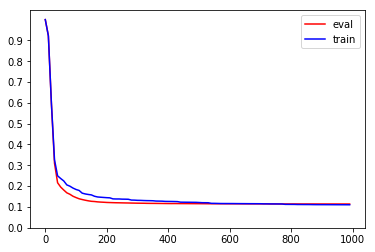

In [31]:
#从最终的训练importnace中看果然是时间序列影响比较大
ret = estimator.evals_result()
train_line = ret['validation_0']['rmspe'][0:1000:10]
eval_line  = ret['validation_1']['rmspe'][0:1000:10]
# evaldata = ret['eval']['rmspe'][0:num_trees:10]
# traindata = ret['train']['rmspe'][0:num_trees:10]
plt.plot(range(0,1000,10),eval_line,color='red',label="eval")
plt.plot(range(0,1000,10),train_line,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()

In [32]:
#获取商店1号的真实数据和预测数据
val_train,val_store,val_test = load_data(Dataset_dir)
val_train = val_train[val_train['Open'] != 0]
val_train = pd.merge(val_train, val_store, on='Store')
test_train = val_train[val_train.Store == 1]
train_val1 = pd.DataFrame(test_train,columns=['Sales'])
train_val1 = np.log1p(train_val1)
build_feature(test_train,True)
test_train.drop('Sales',axis=1,inplace=True)
pred = estimator.predict(test_train)
train_val2 = pd.DataFrame(pred,columns=['Sales'])

D:\AnaconDA\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
D:\AnaconDA\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
D:\AnaconDA\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\AnaconDA\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

int64
Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


D:\AnaconDA\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


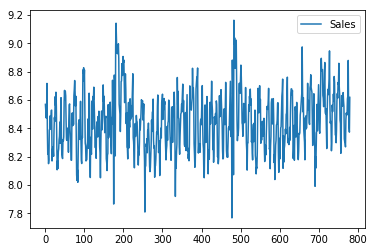

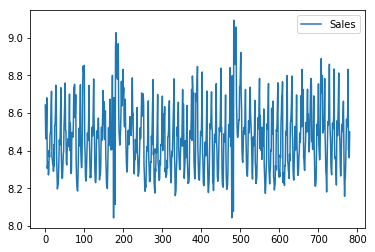

In [33]:
train_val1.plot.line()
train_val2.plot.line()

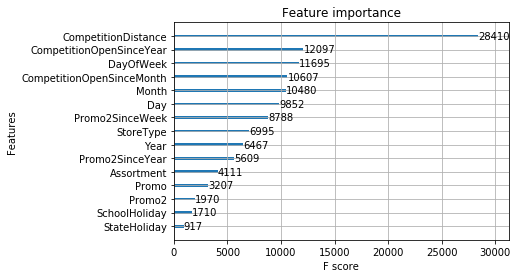

In [34]:
xgb.plot_importance(estimator.get_booster())

In [ ]:
#stacking 进行优化改善
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
rf = RandomForestRegressor(n_estimators=1000,max_depth = 10,verbose=2)
br = BaggingRegressor(n_estimators = 100,verbose = 2)
dt = DecisionTreeRegressor(max_depth = 10)
estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, gamma = 0.4,n_estimators=1000,subsample=0.8,colsample_bytree=0.7,nthread=4,scale_pos_weight=1)
stregr = StackingRegressor(regressors=[rf,br,dt], 
                           meta_regressor=estimator)
stregr.fit(X_train,Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 1000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building

building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tre

building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tre

building tree 954 of 1000
building tree 955 of 1000
building tree 956 of 1000
building tree 957 of 1000
building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 47.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 100 for this parallel run (total 100)...
Building estimator 2 of 100 for this parallel run (total 100)...
Building estimator 3 of 100 for this parallel run (total 100)...
Building estimator 4 of 100 for this parallel run (total 100)...
Building estimator 5 of 100 for this parallel run (total 100)...
Building estimator 6 of 100 for this parallel run (total 100)...
Building estimator 7 of 100 for this parallel run (total 100)...
Building estimator 8 of 100 for this parallel run (total 100)...
Building estimator 9 of 100 for this parallel run (total 100)...
Building estimator 10 of 100 for this parallel run (total 100)...
Building estimator 11 of 100 for this parallel run (total 100)...
Building estimator 12 of 100 for this parallel run (total 100)...
Building estimator 13 of 100 for this parallel run (total 100)...
Building estimator 14 of 100 for this parallel run (total 100)...
Building estimator 15 of 100 for this parallel run (total 100)...
Building estimator 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [37]:
#预测测试数据
regetTest = pd.read_csv("./test.csv")
replaceID = regetTest[regetTest.Open == 0.0]['Id']
print(replaceID.values)
test_probs = estimator.predict(test)
result = pd.DataFrame({"Id": TESTID , 'Sales': np.exp(test_probs)})
result.loc[result['Id'].isin(replaceID.values),'Sales'] = 0

[  544   677   841 ... 40230 40231 40232]


In [38]:
#预测测试数据输出
result.to_csv("xgboost_submission.csv", index=False)